# Simpy Basics
SimPy is a process-based discrete-event simulation framework based on Python. In simpy, Python generator is used a lot. Here we use simpy to build queueing system mainly.

In [1]:
import numpy as np
import simpy
from scipy.stats import expon, norm, gamma, uniform

## Basic Concepts:
- `env = simpy.Environment()`: create a simpy environment
- `env.process(some_process())`: define a process
- `env.run(until=T)`: start simulating the environment (until time T)
- `env.timeout(dt)`: define an event that happens after time dt
- `env.now`: current time
- `yield some_event`: yielding an event causes the time to be incremented

#### Example: simulate arrival times
- arrivals: poisson process with rate $\lambda$
- until time T

In [10]:
np.random.seed(42)

def arrivals(lmbda):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        print(env.now)

lmbda = 1
env = simpy.Environment()
env.process(arrivals(lmbda))
env.run(until=10) 

0.4692680899768591
3.4793895208943804
4.79613521443983
5.709077768215783
5.87870263867813
6.048298930592734
6.108137699201415
8.119368563681356
9.03845071730862


## Events
In simpy, an event has two statuses:
- triggered: the event has been added to the pending event list. Think about a customer who enters the system.
- processed: the event has happened, and has been removed from the pending event list. Think about a customer who starts the service.

We can check event status using `some_event.triggered` and `some_event.processed`. 

### Timeout Event
Timeout event is used a lot. It will record the time for us.

In [11]:
np.random.seed(42)

def arrivals(lmbda):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        print('before yield:', arrival.triggered, arrival.processed)
        print('time before yield:', env.now)
        print('next arrival time:', env.now + dt)
        yield arrival
        print('after yield:', arrival.triggered, arrival.processed)
        print('time after yield:', env.now, "\n")

lmbda = 1
env = simpy.Environment()
env.process(arrivals(lmbda))
env.run(until=5) 

before yield: True False
time before yield: 0
next arrival time: 0.4692680899768591
after yield: True True
time after yield: 0.4692680899768591 

before yield: True False
time before yield: 0.4692680899768591
next arrival time: 3.4793895208943804
after yield: True True
time after yield: 3.4793895208943804 

before yield: True False
time before yield: 3.4793895208943804
next arrival time: 4.79613521443983
after yield: True True
time after yield: 4.79613521443983 

before yield: True False
time before yield: 4.79613521443983
next arrival time: 5.709077768215783


### Generic Event
Besides timeout event, we can also define an event by ourselves using `some_event = env.event()`. 
- When this event is created, the status of this event is "triggered=False, processed=False".
- When `some_event.succeed()` is called, the status of this event is "triggered=True, processed=False". This event is now added to the pending event list. 
- When `yield some_event` is called inside a function, the status of this event becomes triggered=True, processed=True.

#### Example: for a single server queueing system, stop the system until 10 arrivals
- define a stop event. When this stop event happens, the system stops simulating.
- We can see that the last customer may not be served. He is still in the queue but the system has stopped.

In [16]:
np.random.seed(42)

def arrivals(lmbda):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        i = i + 1
        print("Customer {} arrives".format(i))
        if i==10:
            stop10.succeed()
            yield stop10

lmbda = 1
env = simpy.Environment()
stop10 = env.event()
print(stop10.triggered, stop10.processed)
env.process(arrivals(lmbda))
env.run(until=stop10)
print(stop10.triggered, stop10.processed)

False False
Customer 1 arrives
Customer 2 arrives
Customer 3 arrives
Customer 4 arrives
Customer 5 arrives
Customer 6 arrives
Customer 7 arrives
Customer 8 arrives
Customer 9 arrives
Customer 10 arrives
True True


# Single Server Queueing System
## General Idea
Basically, two kinds of processes are included in a single server queueing system.
- Arrival process: 1 process including n arrival events. It starts when the environment starts.
- Service Process: n processes for n arrivals. Each process ends when the service is done.

For service processes:
- define a server: use `server=simpy.Resource(env, capacity=1)` to define a normal single server
- request a server: when a customer arrives, send a request to the server using `rqt = server.request()` and creates an event called `rqt`. **After sending the request, the customer enters the system**.
- provide service: start the service using `yield env.timeout(x)`. **After the yield, dt is added**.
- release the server: when the service is done, release the server using `server.release(rqt)`

Some details:
- `server.users`: all the users in service (list of Request events for the processes that are currently using the resource)
    - the number of customers in service: `len(server.users)` or `server.count` (for a single server system, the value is 0/1)
- `server.queue`: all the users in queue (list of pending Request events)
    - the length of the queue: `len(server.queue)`

<div>
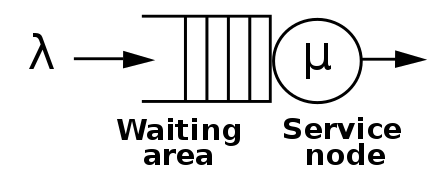
</div>

## Examples

### basic example
- arrivals: poisson process with rate $\lambda$
- service: exponential time with rate $\beta$
- until time T

In [92]:
np.random.seed(42)

def arrivals(lmbda, beta):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        print('customer {} arrived at {}'.format(i, env.now))
        env.process(service(beta, i))
        i = i + 1

def service(beta, i):
    rqt = server.request()
#     print('customer {} arrived at {}'.format(i, env.now))
    yield rqt
    print('customer {} started the service at {}'.format(i, env.now))
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    server.release(rqt)
    print('customer {} finished service and left the system at {}'.format(i, env.now))
    
T = 2
lmbda = 6
beta = 3

env = simpy.Environment()
env.process(arrivals(lmbda, beta))
server = simpy.Resource(env, capacity=1)
env.run(until=T)

customer 0 arrived at 0.07821134832947652
customer 0 started the service at 0.07821134832947652
customer 0 finished service and left the system at 0.5171265795112929
customer 1 arrived at 0.5798982534823967
customer 1 started the service at 0.5798982534823967
customer 1 finished service and left the system at 0.6364398769698454
customer 2 arrived at 0.7320553457783888
customer 2 started the service at 0.7320553457783888
customer 2 finished service and left the system at 0.7520016019812824
customer 3 arrived at 0.760321394430823
customer 3 started the service at 0.760321394430823
customer 3 finished service and left the system at 1.066682112306578
customer 4 arrived at 1.0955265385108128
customer 4 started the service at 1.0955265385108128
customer 4 finished service and left the system at 1.1024596411771923
customer 5 arrived at 1.3007348821282445
customer 5 started the service at 1.3007348821282445
customer 6 arrived at 1.8846611279879633
customer 5 finished service and left the syste

### process N arrivals, get the expected time that an customer spends in the system
- here the service time is $Gamma(\alpha, \beta)$

In [58]:
np.random.seed(42)

def arrivals(X, env, server):
    for i in range(0, N):
        dt = env.timeout(expon.rvs(scale=1/lmbda))
        yield dt
        env.process(service(i, X, env, server))
        
def service(i, X, env, server):
    rqt = server.request()
    t0 = env.now
    yield rqt
    st = env.timeout(gamma.rvs(alpha, scale=1/beta))
    yield st
    server.release(rqt)
    t1 = env.now
    X[i] = t1 - t0

N = 10
lmbda = 1
alpha = 2
beta = 2

def run_simulation():
    X = np.zeros(N)
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(X, env, server))
    env.run()
    return np.mean(X)

simulations = [run_simulation() for _ in range(1000)]
print(np.mean(simulations))

2.273905491200573


### stop system after N arrivals
- Note that the last 3 customers arrived but didn't get served
- a defined stop event is used here

In [51]:
np.random.seed(42)

def arrivals(lmbda, beta):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        env.process(service(beta, i))
        i = i + 1
        if i==N:
            stop10.succeed()
            yield stop10

def service(beta, i):
    rqt = server.request()
    print('customer {} arrived at {}'.format(i, env.now))
    yield rqt
    dt = expon.rvs(scale=1/beta)
    yield env.timeout(dt)
    print('customer {} departed at {}'.format(i, env.now))
    server.release(rqt)

N = 10
lmbda = 2
beta = 1

env = simpy.Environment()
server = simpy.Resource(env, capacity=1)
stop10 = env.event()
print(stop10.triggered, stop10.processed)
env.process(arrivals(lmbda, beta))
env.run(until=stop10)
print(stop10.triggered, stop10.processed)

False False
customer 0 arrived at 0.23463404498842955
customer 0 departed at 1.5513797385338788
customer 1 arrived at 1.7396947604471902
customer 1 departed at 1.9093196309095364
customer 2 arrived at 2.196166037335167
customer 2 departed at 2.2560048059438476
customer 3 arrived at 2.280964183292469
customer 3 departed at 3.200046336919734
customer 4 arrived at 3.286579615532439
customer 4 departed at 3.3073789235315774
customer 5 arrived at 3.902204646384734
customer 6 arrived at 5.65398338396389
customer 5 departed at 5.688634189739409
customer 7 arrived at 5.7733271965883635
customer 8 arrived at 5.874632908004492
customer 6 departed at 5.889313178489072
customer 9 arrived at 6.056009772734731
True True


### stop system at time T
- keep track of arrival times and departure times

In [45]:
np.random.seed(42)

def arrivals(env, server, lmbda, beta, A, D):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        A.append(env.now) #arrival time
        env.process(service(env, server, beta, A, D))
    
    
def service(env, server, beta, A, D):
    rqt = server.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    D.append(env.now) #departure time
    server.release(rqt)
    
def simulate():
    A = [] #customer arrival times
    D = [] #customer departure times
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server, lmbda, beta, A, D))
    env.run(until=T)
    return A, D
    
T = 3
lmbda = 3
beta = 2
A, D = simulate()
print(A)
print(D)

[0.15642269665895303, 1.1597965069647933, 1.4641106915567776, 1.520642788861646, 2.1910530770216257, 2.601469764256489]
[0.8147955434316777, 1.2446089421959665, 1.494030075861118, 1.9801838656752784, 2.201452731021195]


#### finish serving customers already in the queue (in the system)
- stop accepting new arrivals until time T but finish serving the customers already in queue
- keep track of arrival times and departure times
- we can use a defined stop event here, we can also do this without stop event

##### Using stop event

In [260]:
np.random.seed(42)

def arrivals(env, server, stop, A, D):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        if env.now < T:
            A.append(env.now) #arrival time
            env.process(service(env, server, A, D))
        elif len(server.queue) + len(server.users) == 0:
            stop.succeed()
            yield stop
            
def service(env, server, A, D):
    rqt = server.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    D.append(env.now) #departure time
    server.release(rqt)
    
def simulate():
    A = [] #customer arrival times
    D = [] #customer departure times
    env = simpy.Environment()
    stop = env.event()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server, stop, A, D))
    env.run(until=stop)
    return A, D

T = 3
lmbda = 3
beta = 2
A, D = simulate()
print(A)
print(D)

[0.15642269665895303, 1.1597965069647933, 1.4641106915567776, 1.520642788861646, 2.1910530770216257, 2.601469764256489]
[0.8147955434316777, 1.2446089421959665, 1.494030075861118, 1.9801838656752784, 2.201452731021195, 3.4946845359338266]


##### Without stop event (use break)

In [265]:
np.random.seed(42)

def arrivals(env, server, A, D):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        if env.now + dt > T:
            break
        yield env.timeout(dt)
        A.append(env.now)
        env.process(service(env, server, A, D))
        
def service(env, server, A, D):
    rqt = server.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    D.append(env.now) #departure time
    server.release(rqt)
    
def simulate():
    A = [] #customer arrival times
    D = [] #customer departure times
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server, A, D))
    env.run()
    return A, D

T = 3
lmbda = 3
beta = 2
A, D = simulate()
print(A)
print(D)

[0.15642269665895303, 1.1597965069647933, 1.4641106915567776, 1.520642788861646, 2.1910530770216257, 2.601469764256489]
[0.8147955434316777, 1.2446089421959665, 1.494030075861118, 1.9801838656752784, 2.201452731021195, 3.4946845359338266]


#### get average time needed for serving remaining customers after system closed (this will decide when the server can go home!)
- compared to the last example, just change the return value to `max(D[-1]-T, 0)`
- simulate multiple times to get the mean

In [43]:
np.random.seed(42)

def arrivals(env, server, stop, A, D):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        if env.now < T:
            A.append(env.now) #arrival time
            env.process(service(env, server, stop, A, D))
        elif len(server.queue) + len(server.users) == 0:
            stop.succeed()
            yield stop
            
def service(env, server, stop, A, D):
    rqt = server.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    D.append(env.now) #departure time
    server.release(rqt)
    
def simulate():
    A = [] #customer arrival times
    D = [] #customer departure times
    env = simpy.Environment()
    stop = env.event()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server, stop, A, D))
    env.run(until=stop)
    return max(D[-1]-T, 0)

T = 3
lmbda = 3
beta = 2
X = [simulate() for i in range(1000)]
print(np.mean(X))

2.1864311849760805


#### finish the services already in progress and kick out customers in queue
- here we don't set until=T, we control in the arrival and service processes
- it is hard to control with stop event, since we need to seperately finish the service already in progress and kick customers in queue. 
    - Using stop event, we can only stop the whole system when we reach time T / when we finish the services for all customers already in queue.

In [148]:
np.random.seed(42)

def arrivals(env, server, A, D):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        if env.now + dt > T:
            break #refuse new arrivals
        yield env.timeout(dt)
        A.append(env.now)
        env.process(service(env, server, A, D, i))
        i = i + 1
            
def service(env, server, A, D, i):
    rqt = server.request()
    yield rqt
    if env.now < T:
        st = expon.rvs(scale=1/beta)
        yield env.timeout(st)
        D.append(env.now)
        server.release(rqt)
    else:
        server.release(rqt) #kick out of queue
    
def simulate():
    A = [] #arrival times
    D = [] #departure times
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server, A, D))
    env.run()
    return A, D

T = 2
lmbda = 5
beta = 1

simulate()

([0.09385361799537183,
  0.6958779041788761,
  0.8784664149340667,
  0.912391389026536,
  0.9463106474094571,
  0.9582784011311932,
  1.3605245740271812,
  1.544341004752634,
  1.5485008663524618],
 [1.410599311540821, 2.641849373245411])

### stop system when N customers in the system, get the expected time
- the stop event must be triggered in the service process since the customer is added to the system **after sending the request**

In [84]:
np.random.seed(42)

def arrivals(env, server, stop):
    while True:
        dt = env.timeout(expon.rvs(scale=1/lmbda))
        yield dt
        env.process(service(env, server, stop))

def service(env, server, stop):
    rqt = server.request()
    system_level = len(server.users) + len(server.queue)
    if system_level == 5:
        stop.succeed()
        yield stop
    yield rqt
    st = env.timeout(expon.rvs(scale=1/beta))
    yield st
    server.release(rqt)

def run_simulation():
    env = simpy.Environment()
    stop = env.event()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server, stop))
    env.run(until=stop)
    return env.now

lmbda = 2
beta = 1
n = 100
T = [run_simulation() for _ in range(n)]

e_T = np.mean(T)
sigma_T = np.std(T, ddof=1)
ci_low = e_T - norm.ppf(.975) * sigma_T / np.sqrt(n)
ci_high = e_T + norm.ppf(.975) * sigma_T / np.sqrt(n)

print(e_T, ci_low, ci_high)

4.051064683234333 3.493652204941856 4.608477161526811


## Applications

#### check which event comes first, cancel event
Suppose a city exists on a continuous grid $[0,1]\times[0,1]$. There is a single ambulance in the city. Calls come into the ambulance according to a Poisson Process with intensity $\lambda=1$ at a location with coordinates $X_i\sim Unif(0,1)$ and $Y_i\sim Unif(0,1)$ (all independent). The ambulance goes to the them from the hospital at $(0.5,0.5)$ and takes them to the hospital. The ambulance moves at a speed of 1 unit of distance per hour, and goes along the shortest path. It waits at the hospital if there are no calls.

When a call comes in, let's generate a random variable $L_i \sim \exp(1/4)$. **Suppose that is the ambulance does not start heading towards them within $L_i$ of call i coming in, the person dies**. Record the times of death. The ambulance will **drop them out the queue at this point using `rqt.cancel()`**. Run the simulation for 24 hours and see how many people die.

Suppose there is traffic, this a random multiplier for the length of each trip that is uniformly distributed between 0.75 and 3.

- `result = yield rqt | env.timeout(x)`: yield whichever of the events comes first
- `if rqt in result`: check whether rqt enters service first before the timeout event
- `rqt.cancel()`: cancel a request, drop the customer out of queue

In [97]:
np.random.seed(42)

def arrivals(env, ambulance, X, Y, L, T):
    i = 0
    while True:
        dt = expon.rvs()
        yield env.timeout(dt)
        X.append(uniform.rvs())
        Y.append(uniform.rvs())
        L.append(expon.rvs(scale=4))
        print('call {} arrives at time {} from location ({}, {})'.format(i, env.now, X[i], Y[i]))
        env.process(service(env, ambulance, X, Y, i, L, T))
        i = i + 1

def service(env, ambulance, X, Y, i, L, T):
    rqt = ambulance.request()
    print('the ambulance is currently serving {} people, there are {} in line'.format(ambulance.count, len(ambulance.queue)))
    result = yield rqt | env.timeout(L[i])
    if rqt not in result:
        T.append(env.now)
        print('person {} dies at {}'.format(i, env.now))
        rqt.cancel()
        print('request {} cancelled'.format(i))
    else:
        traffic = 2.25 * uniform.rvs() + 0.75
        dt = (2 * np.sqrt((X[i] - 0.5)**2 + (Y[i] - 0.5)**2)) * traffic
        yield env.timeout(dt)
        print('the ambulance finishes request {} at {}'.format(i, env.now))
        ambulance.release(rqt)
    
def simulate():
    X = []
    Y = []
    L = [] #Li
    T = [] #death times
    env = simpy.Environment()
    ambulance = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, ambulance, X, Y, L, T))
    env.run(until=24)
    print(T)
    return len(T)
    
simulate()

call 0 arrives at time 0.4692680899768591 from location (0.9507143064099162, 0.7319939418114051)
the ambulance is currently serving 1 people, there are 0 in line
call 1 arrives at time 0.6388929604392054 from location (0.05808361216819946, 0.8661761457749352)
the ambulance is currently serving 1 people, there are 1 in line
the ambulance finishes request 0 at 1.585486238077061
call 2 arrives at time 1.8701430221437958 from location (0.9699098521619943, 0.8324426408004217)
the ambulance is currently serving 1 people, there are 1 in line
call 3 arrives at time 2.070822010893459 from location (0.18340450985343382, 0.3042422429595377)
the ambulance is currently serving 1 people, there are 2 in line
the ambulance finishes request 1 at 2.4995159461421084
call 4 arrives at time 2.636359077673796 from location (0.6118528947223795, 0.13949386065204183)
the ambulance is currently serving 1 people, there are 2 in line
call 5 arrives at time 3.092636295894643 from location (0.45606998421703593, 0.7

8

# Some Examples Before Multi-server Queue

### Print number of customers ahead of each customer
In the queueing system, simpy automatly deals with the order of arrivals and services for us, that is, if the server is busy when a customer arrives, the customer will enter the queue, but the arrival process still happens in parallel.

We can check the number of people ahead of a customer using `len(server.queue)+server.count`.

In [99]:
np.random.seed(42)

def customer(lmbda, beta):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        env.process(service(beta, i))
        i = i + 1

def service(beta, i):
    print('customer {} arrived at {}'.format(i, env.now))
    print('there are {} people ahead of him'.format(len(server.queue)+server.count))
    rqt = server.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    server.release(rqt)
    print('customer {} left the system at {}'.format(i, env.now))
    
T = 2
lmbda = 6
beta = 3

env = simpy.Environment()
env.process(customer(lmbda, beta))
server = simpy.Resource(env, capacity=1)
env.run(until=T)

customer 0 arrived at 0.07821134832947652
there are 0 people ahead of him
customer 0 left the system at 0.5171265795112929
customer 1 arrived at 0.5798982534823967
there are 0 people ahead of him
customer 1 left the system at 0.6364398769698454
customer 2 arrived at 0.7320553457783888
there are 0 people ahead of him
customer 2 left the system at 0.7520016019812824
customer 3 arrived at 0.760321394430823
there are 0 people ahead of him
customer 3 left the system at 1.066682112306578
customer 4 arrived at 1.0955265385108128
there are 0 people ahead of him
customer 4 left the system at 1.1024596411771923
customer 5 arrived at 1.3007348821282445
there are 0 people ahead of him
customer 6 arrived at 1.8846611279879633
there are 1 people ahead of him
customer 5 left the system at 1.8962113965798029
customer 7 arrived at 1.9244423988627877
there are 1 people ahead of him
customer 8 arrived at 1.9582109693348304
there are 2 people ahead of him
customer 6 left the system at 1.9631043928296907


### Consider a special situation for the last example
- We have 2 kinds of customers. They may have different arrival rate (different frequency).
- We have 2 servers. Customer1 needs to be served by the 2 servers simultaneously (not parallel/series multi-server queueing system). Think about Hair and Nail Salon. Customer2 only need to be served by 1 server (only need a haircut). 

In [102]:
np.random.seed(42)

def customer1(lmbda, beta): #customer1 needs both service1 and service2
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        #start service1 and service2 simultaniously
        env.process(service1(beta, i))
        env.process(service2(beta, i))
        i = i + 1

def customer2(lmbda, beta): #customer2 needs only service1
    i = 0
    while True:
        dt = expon.rvs(scale=1/(lmbda/2))
        arrival = env.timeout(dt)
        yield arrival
        env.process(service1(beta, i))
        i = i + 1

def service1(beta, i):
    print('customer {} arrived at {}'.format(i, env.now))
    print('there are {} people ahead of him for server 1'.format(len(server1.queue)+server1.count))
    rqt = server1.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    server1.release(rqt)
    print('customer {} left server 1 at {}'.format(i, env.now))
    
def service2(beta, i):
    print('customer {} arrived at {}'.format(i, env.now))
    print('there are {} people ahead of him for server 2'.format(len(server2.queue)+server2.count))
    rqt = server2.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    server2.release(rqt)
    print('customer {} left server 2 at {}'.format(i, env.now))
    
T = 2
lmbda = 6
beta = 3

env = simpy.Environment()
#2 parallel arrival processes
env.process(customer1(lmbda, beta))
env.process(customer2(lmbda, beta))
server1 = simpy.Resource(env, capacity=1)
server2 = simpy.Resource(env, capacity=1)
env.run(until=T)

customer 0 arrived at 0.07821134832947652
there are 0 people ahead of him for server 1
customer 0 arrived at 0.07821134832947652
there are 0 people ahead of him for server 2
customer 0 left server 2 at 0.13475297181692528
customer 1 arrived at 0.2976689639203847
there are 1 people ahead of him for server 1
customer 1 arrived at 0.2976689639203847
there are 0 people ahead of him for server 2
customer 1 left server 2 at 0.31761522012327825
customer 2 arrived at 0.3259350125728189
there are 2 people ahead of him for server 1
customer 2 arrived at 0.3259350125728189
there are 0 people ahead of him for server 2
customer 0 left server 1 at 0.3825255329214609
customer 2 left server 2 at 0.6322957304485737
customer 3 arrived at 0.6611401566528088
there are 2 people ahead of him for server 1
customer 3 arrived at 0.6611401566528088
there are 0 people ahead of him for server 2
customer 4 arrived at 0.6646067079859985
there are 3 people ahead of him for server 1
customer 4 arrived at 0.6646067079

### Yield a process
- if `yield env.process(service(beta, i))`, this means other customers need to wait for this customer to finish his service (e.g. when customer 1 arrives, he needs to wait for customer 0 to finish service, so basically customer 1 hasn't entered the system.)

- in the result, we can see that although customer 0 is still in service when customer 1 arrives, customer 1 needs to wait until customer 1 finishes the service, so "there are 0 customers ahead of customer 1" when customer start the service process

In [110]:
np.random.seed(42)

def customer(lmbda, beta):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        yield env.process(service(beta, i)) #yield a process
        i = i + 1

def service(beta, i):
    print('customer {} arrived at {}'.format(i, env.now))
    print('there are {} people ahead of him'.format(len(server.queue)+server.count))
    rqt = server.request()
    yield rqt
    service_time = expon.rvs(scale=1/beta)
    service = env.timeout(service_time)
    yield service
    server.release(rqt)
    print('customer {} left the system at {}'.format(i, env.now))
    
T = 5
lmbda = 6
beta = 3

env = simpy.Environment()
env.process(customer(lmbda, beta))
server = simpy.Resource(env, capacity=1)
env.run(until=T)

customer 0 arrived at 0.07821134832947652
there are 0 people ahead of him
customer 0 left the system at 1.081585158635317
customer 1 arrived at 1.3010427742262252
there are 0 people ahead of him
customer 1 left the system at 1.6053569588182095
customer 2 arrived at 1.633627770561934
there are 0 people ahead of him
customer 2 left the system at 1.6901598678668024
customer 3 arrived at 1.7001329959682492
there are 0 people ahead of him
customer 3 left the system at 2.370543284128229
customer 4 arrived at 2.5237236430661065
there are 0 people ahead of him
customer 4 left the system at 2.93414033030097
customer 5 arrived at 2.9376068816341596
there are 0 people ahead of him
customer 5 left the system at 4.105459373353597
customer 6 arrived at 4.403197630579376
there are 0 people ahead of him
customer 6 left the system at 4.482760172329025
customer 7 arrived at 4.516206670453968
there are 0 people ahead of him
customer 7 left the system at 4.583743811398054
customer 8 arrived at 4.644202766

# Multiple Server Queueing System

## Multi-server in Series (Servers can be different)
A customer is first served by server 1, then served by server 2. The arrival process stays unchanged. There are 2 ways to model the service process.

Method 1: multiple service processes
- After being served by server 1, the customer departure can be treated as a new arrival process for server 2. 
    - after `server1.release(rqt)`, start a new service process for server 2 using `env.process(service2()).
- Then, we generate the second service process just like before.

Method 2: one long service process
- Just add more service events in one long service process, then the code will be executed sequentially.

#### Basic Example

In [113]:
# Method 2 (with 2 servers)
# here we use the same service time for each server
np.random.seed(42)

def arrivals(env, server1, server2, A, D):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        A.append(env.now)
        env.process(service(env, server1, server2, A, D, i))
        i = i + 1

def service(env, server1, server2, A, D, i):
    rqt1 = server1.request()
    yield rqt1
    dt1 = expon.rvs(scale=1/beta1)
    yield env.timeout(dt1)
    server1.release(rqt1)
    
    rqt2 = server2.request()
    yield rqt2
    dt2 = expon.rvs(scale=1/beta2)
    yield env.timeout(dt2)
    server2.release(rqt2)
    
    D.append(env.now)

def simulate():
    A = [] #arrival times
    D = [] #departure times
    env = simpy.Environment()
    server1 = simpy.Resource(env, capacity=1)
    server2 = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server1, server2, A, D))
    env.run(until=T)
    return A, D
    
T = 4
lmbda = 2
beta1 = 1
beta2 = 2

simulate()

([0.23463404498842955,
  1.7396947604471902,
  1.8245071956783634,
  1.8544265799827038,
  2.8600420122226735,
  3.753256783900011,
  3.8726005965244847,
  3.9729400908993164],
 [2.0078510154218554, 2.6234760462741504, 2.8387728599886293])

#### n series servers: we can create a list of servers

In [116]:
np.random.seed(42)

def arrivals(env, servers, A, D):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        A.append(env.now)
        env.process(service(env, servers, A, D, i))
        i = i + 1

def service(env, servers, A, D, i):
    n = len(servers)
    for j in range(n):
        rqt = servers[j].request()
        yield rqt
        dt = expon.rvs(scale=1/betas[j])
        yield env.timeout(dt)
        servers[j].release(rqt)
    
    D.append(env.now)

def simulate(n): #n: number of servers
    A = []
    D = []
    env = simpy.Environment()
    servers = [simpy.Resource(env, capacity=1) for i in range(n)]
    env.process(arrivals(env, servers, A, D))
    env.run(until=T)
    return A, D
    
T = 4
lmbda = 2
betas = [1,2,3]

simulate(3)

([0.23463404498842955,
  1.7396947604471902,
  1.8245071956783634,
  1.8544265799827038,
  2.8600420122226735,
  2.960381506597505,
  3.061687218013634,
  3.2430640827438726,
  3.525832616134041,
  3.6979441124110117],
 [2.4182677026567188, 3.5861201943761563, 3.7716661539088436])

## Multi-server in Parallel (Identical Servers)
In simpy, we can simply set the capacity of a server to change the parallel number of servers using `servers=simpy.Resource(env, capacity=n)`
- only for identical servers
- cannot track the details of one specific server 

In [120]:
np.random.seed(42)

def arrivals(env, server, A, D):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        A.append(env.now)
        env.process(service(env, server, A, D, i))
        i = i + 1
            
def service(env, server, A, D, i):
    print('customer {} arrives at {}'.format(i, env.now))
    rqt = server.request()
    print('there are currently {} customers in service'.format(len(server.users)))
    print('there are currently {} customers in queue'.format(len(server.queue)))
    yield rqt
    dt = expon.rvs(scale=1/beta)
    service = env.timeout(dt)
    yield service
    print('customer {} leaves at {}'.format(i, env.now))
    D.append(env.now) #departure time
    server.release(rqt)
    
def simulate(j): #j: number of servers (capacity of server)
    A = [] #arrival times
    D = [] #departure times
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=j)
    env.process(arrivals(env, server, A, D))
    env.run(until=T)
    return A, D

T = 2
lmbda = 5
beta = 1

simulate(2)

customer 0 arrives at 0.09385361799537183
there are currently 1 customers in service
there are currently 0 customers in queue
customer 1 arrives at 0.6958779041788761
there are currently 2 customers in service
there are currently 0 customers in queue
customer 1 leaves at 0.8655027746412224
customer 2 arrives at 0.8784664149340667
there are currently 2 customers in service
there are currently 0 customers in queue
customer 3 arrives at 0.9123856733169877
there are currently 2 customers in service
there are currently 1 customers in queue
customer 2 leaves at 0.9383051835427474
customer 4 arrives at 1.3146318462129756
there are currently 2 customers in service
there are currently 1 customers in queue
customer 0 leaves at 1.410599311540821
customer 4 leaves at 1.4313986195399597
customer 5 arrives at 1.5608818585538937
there are currently 2 customers in service
there are currently 0 customers in queue
customer 3 leaves at 1.857387337170012


([0.09385361799537183,
  0.6958779041788761,
  0.8784664149340667,
  0.9123856733169877,
  1.3146318462129756,
  1.5608818585538937],
 [0.8655027746412224,
  0.9383051835427474,
  1.410599311540821,
  1.4313986195399597,
  1.857387337170012])

## Generalized Multi-server in parallel (different servers)
Here we consider multiple parallel servers which are not identical. Suppose there are 2 different servers. In this situation, when a customer arrives, he sends a request to server 1 and also a request to server 2. We may have 2 possible cases:
- Case 1: one of the 2 servers becomes available first (let's say server 1)
    - In this case, the customer will cancel the request to server 2 and move on with server 1.
- Case 2: both servers become available at the same time
    - The customer will randomly choose one server and cancel the request to the other server.
    
Here we need other functions in simpy:
- `yield simpy.AnyOf(env,[rqt1,rqt2,rqt3,...])`: creates an event that attempts to process the earliest event, same as `yield event1|event2|event3|...`
    - save the return result using `result=yield rqt1|rqt2`
    - check which case we fall into using
        - Case 1: `rqt1 in result` and `rqt2 not in result`
            - cancel rqt2: `rqt2.cancel()`
            - get service time of server1: `env.timeout(service time)`
            - release server1: `server1.release(rqt1)`
        - Case 2: `rqt1 in result` and `rqt2 in result`
            - using `np.random.rand()>0.5` to choose randomly
        - Case 3: `rqt2 in result` and `rqt1 not in result`
            - similar to case 1

more: if we want to launch many requests as parallel processes and let them be processed in parallel, we can use `yield simpy.AllOf(env, X)` to yield all of them (i.e. move the timer inside the service request to when we are all done, X is the collection of processes

In [165]:
np.random.seed(42)

def arrivals(env, server1, server2, A, D):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        A.append(env.now)
        env.process(service(env, server1, server2, A, D))

def service(env, server1, server2, A, D):
    rqt1 = server1.request()
    rqt2 = server2.request()
    result = yield rqt1 | rqt2 #yield simpy.AnyOf(env,[rqt1,rqt2])
    if rqt1 in result and rqt2 in result:
        if np.random.rand() > 0.5:
            rqt2.cancel()
            dt1 = expon.rvs(scale=1/beta1)
            service1 = env.timeout(dt1)
            yield service1
            server1.release(rqt1)
        else:
            rqt1.cancel()
            dt2 = expon.rvs(scale=1/beta2)
            service2 = env.timeout(dt2)
            yield service2
            server2.release(rqt2)
    elif rqt1 in result and rqt2 not in result:
        rqt2.cancel()
        dt1 = expon.rvs(scale=1/beta1)
        service1 = env.timeout(dt1)
        yield service1
        server1.release(rqt1)
    else: #both in result, choose server2
        rqt1.cancel()
        dt2 = expon.rvs(scale=1/beta2)
        service2 = env.timeout(dt2)
        yield service2
        server2.release(rqt2)
    D.append(env.now)

def simulate():
    A = []
    D = []
    env = simpy.Environment()
    server1 = simpy.Resource(env, capacity=1)
    server2 = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server1, server2, A, D))
    env.run(until=T)
    return A, D
    
T = 3
lmbda = 3
beta1 = 2
beta2 = 1

simulate()

([0.15642269665895303,
  1.1597965069647933,
  1.216338130452242,
  1.2362843866551356,
  1.9066946748151155,
  1.913627777481495],
 [0.6128939735469296,
  1.244594652922096,
  1.7041357297357282,
  2.3197607605880233])

## Multi-server in parallel with multiple queues
Each different parallel server has its own queue. When a customers arrives, he will choose the server with the shortest queue. Use `(len(server.queue)+server.count))` to check the total length of a server (including the customer being served)

In [168]:
import numpy as np
import simpy
from scipy.stats import expon

np.random.seed(42)

def arrivals(env, servers, A, D):
    while True:
        dt = expon.rvs(scale=1/lmbda)
        arrival = env.timeout(dt)
        yield arrival
        A.append(env.now)
        env.process(service(env, servers, A, D))

def service(env, servers, A, D):
    lens = np.array([len(server.queue)+server.count for server in servers])
    ind = np.argmin(lens) #this can be changed if the customer has a different rule of choosing the server
    rqt = servers[ind].request()
    yield rqt
    dt = expon.rvs(scale=1/beta[ind])
    service = env.timeout(dt)
    yield service
    servers[ind].release(rqt)
    
    D.append(env.now)

def simulate(n): #n: number of servers
    A = []
    D = []
    env = simpy.Environment()
    servers = [simpy.Resource(env, capacity=1) for i in range(n)]
    env.process(arrivals(env, servers, A, D))
    env.run(until=T)
    return A, D
    
T = 4
lmbda = 2
# beta = 2
beta = [1, 4, 3]

simulate(3)

([0.23463404498842955,
  1.7396947604471902,
  2.196166037335167,
  2.280964183292469,
  3.286579615532439,
  3.902204646384734],
 [1.5513797385338788,
  1.9093196309095364,
  2.2560048059438476,
  3.200046336919734,
  3.3073789235315774])

# Queueing System with Advanced Features
- Priority resource: a customer can get to the front of the queue with some priority
- Process interruption: customer take breaks / drop out of line / etc
- Preemptive resource: a customer with higher priority will interrupt the service of another customer

## Priority Resource
- assign each customer a priority, this will decide **the order in the queue**
- upon arrival, a customer will 
    - line up behind people with the higher or the same priority
    - line up before people with a lower priority
- **once a customer starts the service, he will not be stopped by another person with a higher priority**

important simpy syntax:
- define a priority resource: `simpy.PriorityResource()`
- send the request with a priority: `resource.request(priority=a)`, **a smaller number indicates a higher priority**

In [214]:
np.random.seed(42)

def arrivals(env, server, A0, A1):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        if uniform.rvs() < 0.5:
            priority = 0 #VIP
            A0.append(env.now)
        else:
            priority = 1 #regulat customer
            A1.append(env.now)
        env.process(service(env, server, i, priority))
        i = i + 1

def service(env, server, i, priority):
    rqt = server.request(priority=priority)
    yield rqt
    st = expon.rvs(scale=1/beta)
    yield env.timeout(st)
    server.release(rqt)

def simulate():
    A0 = []
    A1 = []
    env = simpy.Environment()
    server = simpy.PriorityResource(env, capacity=1)
    env.process(arrivals(env, server, A0, A1))
    env.run(until=T)
    return A0, A1

T = 5
lmbda = 2
beta = 1
simulate()


([0.8930068917611542,
  0.9778050377184568,
  2.8870348956353333,
  3.2589988110657604,
  3.7321842480156597,
  4.520443148845308],
 [0.23463404498842955,
  1.9834204699584266,
  1.9938201239579958,
  3.960322857126083,
  4.071690788190428,
  4.55407511428496])

## Process Interruption
**Interruptions when the customer is in line**

examples:
- when a customer is waiting in line, he may receive a call, then he needs to leave the queue to answer the call (and then he may come back. )
- when a customer is waiting in line, he has a finite patience time. If he is out of patience, he will leave.

We can create two processes. One process models the arrival of the interruption event (phone call / impatience). The other process models the regular service process. Once an interruption happens, the service process will be interrupted. This customer will stop waiting in the queue, spend some time and then arrive again / leave the system

import simpy codes:
- `simpy.Interrupt`: used in `try except` to check if the process is interrupted
- `rqt.processed`: used in the interruption process to check if the customer is in service (if `rqt.processed==False`, this customer is still in queue, so he can be interrupted.

### Basic Example

In [211]:
np.random.seed(42)

def arrivals(env, server):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        print('customer {} arrives at {}'.format(i, env.now))
        rqt = server.request() #send the request in the arrival process
        s1 = env.process(service(env, server, i, rqt)) #give the service process a name
        env.process(patience(env, i, s1, rqt)) #add the interruption process
        i = i + 1

def service(env, server, i, rqt):
    try:
        yield rqt
        print('customer {} starts service at {}'.format(i, env.now))
        st = expon.rvs(scale=1/beta1)
        yield env.timeout(st)
        print('customer {} finishes service at {}'.format(i, env.now))
        server.release(rqt)
    except simpy.Interrupt: #if the process is interrupted
        rqt.cancel()
        print('customer {} run out of patience at {} and leaves'.format(i, env.now))
    
def patience(env, i, s1, rqt):
    pt = expon.rvs(scale=1/beta2)
    yield env.timeout(pt)
    if rqt.processed == False: #if the customer is still in line and runs out of patience
        s1.interrupt()
    
def simulate():
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals(env, server))
    env.run(until=T)

T = 5
lmbda = 2
beta1 = 1
beta2 = 5

simulate()


customer 0 arrives at 0.23463404498842955
customer 0 starts service at 0.23463404498842955
customer 0 finishes service at 1.147576598764383
customer 1 arrives at 1.7396947604471902
customer 1 starts service at 1.7396947604471902
customer 1 finishes service at 1.799533529055871
customer 2 arrives at 1.8245071956783634
customer 2 starts service at 1.8245071956783634
customer 3 arrives at 2.830122627918333
customer 4 arrives at 2.8405222819179023
customer 4 run out of patience at 2.888259806967692 and leaves
customer 2 finishes service at 3.055757257382954
customer 3 starts service at 3.055757257382954
customer 3 finishes service at 3.2564362461326173
customer 5 arrives at 3.73373705359524
customer 5 starts service at 3.73373705359524
customer 6 arrives at 3.8350427650113685
customer 6 run out of patience at 3.903887363522157 and leaves
customer 7 arrives at 4.117811298401537
customer 7 run out of patience at 4.1478582041470045 and leaves
customer 5 finishes service at 4.477664884456094
c

### different kinds of interruptions: interrupt in service / interrupt in queue
When `rqt.processed == True`, the customer may be in service or have left the system. We can divide these two situations.

If `rqt in server.users`, the customer is still in service.

some codes:
- `try ... except simpy.Interrupt as sint`
- `sint.cause`
- `s1.interrupt('case 1')`

In [256]:
def arrivals():
    i = 0
    rqt_list = {}
    while True:
        dt = expon.rvs()
        yield env.timeout(dt)
        s1 = env.process(service(i, rqt_list))
        env.process(patience(s1, i, rqt_list))
        i = i + 1

def service(i, rqt_list):
    rqt = server.request()
    rqt_list[i] = rqt
    try:
        yield rqt
        dt = expon.rvs()
        yield env.timeout(dt)
        server.release(rqt)
    except simpy.Interrupt as sint:
        if sint.cause == 'case 1': #get impatient when the customer is in queue
            rqt.cancel()
        elif sint.cause == 'case 2': #get impatient when the customer is in service
            server.release(rqt)

def patience(s1, i, rqt_list):
    while True:
        dt = expon.rvs()
        yield env.timeout(dt) 
        if rqt_list[i].processed == False: #in queue
            s1.interrupt('case 1')
        elif rqt_list[i] in server.users: #still in service
            s1.interrupt('case 2')
        else: #have finished the service and left the system
            break

def simulate():
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals())
    env.run(until=10)

simulate()

### After the interruption, the customer comes to the back of the queue
- Add a while loop in the service process, then replace the old rqt in rqt_list with a new one

In [259]:
def arrivals():
    i = 0
    rqt_list = {}
    while True:
        dt = expon.rvs()
        yield env.timeout(dt)
        s1 = env.process(service(i, rqt_list))
        env.process(patience(s1, i, rqt_list))
        i = i + 1

def service(i, rqt_list):
    rqt = server.request()
    rqt_list[i] = rqt
    while True:
        try:
            yield rqt
            dt = expon.rvs()
            yield env.timeout(dt)
            server.release(rqt)
        except simpy.Interrupt as sint:
            if sint.cause == 'case 1': #get impatient when the customer is in queue
                rqt.cancel()
            elif sint.cause == 'case 2': #get impatient when the customer is in service
                server.release(rqt)
            rqt = server.request()
            rqt_list[i] = rqt

def patience(s1, i, rqt_list):
    while True:
        dt = expon.rvs()
        yield env.timeout(dt) 
        if rqt_list[i].processed == False: #in queue
            s1.interrupt('case 1')
        elif rqt_list[i] in server.users: #still in service
            s1.interrupt('case 2')
        else: #have finished the service and left the system
            break

def simualte():
    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)
    env.process(arrivals())
    env.run(until=10)
    
simualte()

## Preemptive Resource
A customer with high priority can get the service first even when a customer with low priority is in the service.

examples
- in an ER (emergency room) system, if we have a patient arriving with a life-threatening symptom, we might want to allow this patient to receive the treatment immediately, which might imply we need to stop serving another patient

One way to do this is to use one additional attribute to indicate whether this request is able to kick out another user with a lower priority. 

important simpy codes:
- `simpy.PreemptiveResource()`
- `resource.request(priority=a, preempt=True/False)`
- `simpy.resources.resource.Preempted`

some conditions:
- Customer 1: priority=0, preempt=False (in service)
- Customer 2: priority=-1, preempt=False (arrives next)
- Customer 3: priority=-1, preempt=True (arrives after customer 2)

    - When customer 2 arrives, customer 1 is receiving the service. Because preemptive is=False, customer 2 will be waiting in the line. 
    - Now, let's assume that when customer 3 arrives, customer 1 and 2 are both still in the system. Even though customer 3 has preemptive=True, customer 3 has to wait after customer 2. This is because customer 3 does not have a higher priority than customer 2. Had customer 2 not been there, customer 3 would have kicked off customer 1.

### Basic example (not so reasonable): directly kicked off

In [227]:
np.random.seed(42)

def arrivals(env, server):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        env.process(service(env, server, i))
        i = i + 1

def service(env, server, i):
    if uniform.rvs() < 0.25: 
        priority = 0
        preempt = True
        print('patient {} is an emergency patient'.format(i))
    else:
        priority = 1
        preempt = False
        print('patient {} is a regular patient'.format(i))
    print('patient {} arrives at {}'.format(i, env.now))
    #a rqt with higher priority and preempt=True can kick off another rqt in service
    rqt = server.request(priority=priority, preempt=preempt)
    yield rqt
    print('patient {} gets the service at {}'.format(i, env.now))
    st = expon.rvs(scale=1/beta)
    try:
        yield env.timeout(st)
        print('patient {} leaves at {}'.format(i, env.now))
        server.release(rqt)
    except: #if the customer is kicked off by another customer
        print('patient {} gets kicked off at {}'.format(i, env.now))
    
def simulate():
    env = simpy.Environment()
    server = simpy.PreemptiveResource(env, capacity=1)
    env.process(arrivals(env, server))
    env.run(until=T)

T = 4
lmbda = 2
beta = 2

simulate()


patient 0 is a regular patient
patient 0 arrives at 0.23463404498842955
patient 0 gets the service at 0.23463404498842955
patient 0 leaves at 0.6911053218764062
patient 1 is an emergency patient
patient 1 arrives at 1.7396947604471902
patient 1 gets the service at 1.7396947604471902
patient 1 leaves at 1.7696141447515306
patient 2 is a regular patient
patient 2 arrives at 1.8245071956783634
patient 2 gets the service at 1.8245071956783634
patient 2 leaves at 2.4401322265306584
patient 3 is a regular patient
patient 3 arrives at 2.830122627918333
patient 3 gets the service at 2.830122627918333
patient 4 is an emergency patient
patient 4 arrives at 2.8405222819179023
patient 3 gets kicked off at 2.8405222819179023
patient 4 gets the service at 2.8405222819179023
patient 4 leaves at 2.941827993334031
patient 5 is a regular patient
patient 5 arrives at 2.959866094542376
patient 5 gets the service at 2.959866094542376
patient 6 is a regular patient
patient 6 arrives at 3.1412429592726148
pa

### More reasonable: go to the front of the line when getting kicked off from the service
Two kinds of customers: priority=0 and preempt=True / priority=2 and preempt=False
- After a customer gets kicked off, send a new request for this customer.
- If we send `rqt = server.request(priority=1, preempt=False)`, the customer will go to the front of the line (since the priority=1, which is higher than priority=2 customer).
- However, if we send `rqt = server.request(priority=2, preempt=False)`, the customer will go to the back of the customers with the same priority.

In [7]:
np.random.seed(42)

def arrivals(env, server):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        env.process(service(env, server, i))
        i = i + 1

def service(env, server, i):
    if uniform.rvs() < 0.25: 
        priority = 0
        preempt = True
        print('patient {} is an emergency patient'.format(i))
    else:
        priority = 2
        preempt = False
        print('patient {} is a regular patient'.format(i))
    print('patient {} arrives at {}'.format(i, env.now))
    #a rqt with higher priority and preempt=True can kick off another rqt in service
    rqt = server.request(priority=priority, preempt=preempt)
    yield rqt
    print('patient {} gets the service at {}'.format(i, env.now))
    st = expon.rvs(scale=1/beta)
    while True:
        try:
            yield env.timeout(st)
            print('patient {} leaves at {}'.format(i, env.now))
            break
        except: #if the customer is kicked off by another customer
            print('patient {} gets kicked off at {}'.format(i, env.now))
            rqt = server.request(priority=1, preempt=False)
            yield rqt
            print('patient {} restarts service at {}'.format(i, env.now))
    server.release(rqt)
            
def simulate():
    env = simpy.Environment()
    server = simpy.PreemptiveResource(env, capacity=1)
    env.process(arrivals(env, server))
    env.run(until=T)

T = 10
lmbda = 1
beta = 2

simulate()


patient 0 is a regular patient
patient 0 arrives at 0.4692680899768591
patient 0 gets the service at 0.4692680899768591
patient 0 leaves at 0.9257393668648357
patient 1 is an emergency patient
patient 1 arrives at 3.4793895208943804
patient 1 gets the service at 3.4793895208943804
patient 1 leaves at 3.5093089051987207
patient 2 is a regular patient
patient 2 arrives at 3.649014391356727
patient 2 gets the service at 3.649014391356727
patient 2 leaves at 4.264639422209022
patient 3 is a regular patient
patient 3 arrives at 5.660245255836666
patient 3 gets the service at 5.660245255836666
patient 4 is an emergency patient
patient 4 arrives at 5.681044563835805
patient 3 gets kicked off at 5.681044563835805
patient 4 gets the service at 5.681044563835805
patient 4 leaves at 5.782350275251933
patient 3 restarts service at 5.782350275251933
patient 5 is a regular patient
patient 5 arrives at 5.919732189084752
patient 6 is a regular patient
patient 6 arrives at 6.2824859185452295
patient 3 

In [6]:
np.random.seed(42)

def arrivals(env, server):
    i = 0
    while True:
        dt = expon.rvs(scale=1/lmbda)
        yield env.timeout(dt)
        env.process(service(env, server, i))
        i = i + 1

def service(env, server, i):
    if uniform.rvs() < 0.25: 
        priority = 0
        preempt = True
        print('patient {} is an emergency patient'.format(i))
    else:
        priority = 2
        preempt = False
        print('patient {} is a regular patient'.format(i))
    print('patient {} arrives at {}'.format(i, env.now))
    #a rqt with higher priority and preempt=True can kick off another rqt in service
    rqt = server.request(priority=priority, preempt=preempt)
    yield rqt
    print('patient {} gets the service at {}'.format(i, env.now))
    st = expon.rvs(scale=1/beta)
    while True:
        try:
            yield env.timeout(st)
            print('patient {} leaves at {}'.format(i, env.now))
            break
        except: #if the customer is kicked off by another customer
            print('patient {} gets kicked off at {}'.format(i, env.now))
            rqt = server.request(priority=2, preempt=False) #here!!!!!!! note the difference of customer 6 in the results
            yield rqt
            print('patient {} restarts service at {}'.format(i, env.now))
    server.release(rqt)
            
def simulate():
    env = simpy.Environment()
    server = simpy.PreemptiveResource(env, capacity=1)
    env.process(arrivals(env, server))
    env.run(until=T)

T = 10
lmbda = 1
beta = 2

simulate()


patient 0 is a regular patient
patient 0 arrives at 0.4692680899768591
patient 0 gets the service at 0.4692680899768591
patient 0 leaves at 0.9257393668648357
patient 1 is an emergency patient
patient 1 arrives at 3.4793895208943804
patient 1 gets the service at 3.4793895208943804
patient 1 leaves at 3.5093089051987207
patient 2 is a regular patient
patient 2 arrives at 3.649014391356727
patient 2 gets the service at 3.649014391356727
patient 2 leaves at 4.264639422209022
patient 3 is a regular patient
patient 3 arrives at 5.660245255836666
patient 3 gets the service at 5.660245255836666
patient 4 is an emergency patient
patient 4 arrives at 5.681044563835805
patient 3 gets kicked off at 5.681044563835805
patient 4 gets the service at 5.681044563835805
patient 4 leaves at 5.782350275251933
patient 3 restarts service at 5.782350275251933
patient 5 is a regular patient
patient 5 arrives at 5.919732189084752
patient 6 is a regular patient
patient 6 arrives at 6.2824859185452295
patient 3 